<br>
<h1 style = "font-size:40px; font-weight : bold; color : skyblue; text-align: center; border-radius: 10px 12px;">Pneumonia Detection: Image Classification with Convolutional Neural Networks </h1>
<br>

---

# <a id="2">Importing Packages and Dataset</a> 

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

/home/rishi/anaconda3/envs/wstf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
import os
import glob
#main_path = "../input/chest-xray-pneumonia/chest_xray/"
main_path = "/home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
df_train.head()

class  \
0  Normal   
1  Normal   
2  Normal   
3  Normal   
4  Normal   

                                                                                                 image  
0  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
1  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
2  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
3  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
4  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...

In [6]:
df_test.head()

class  \
0  Normal   
1  Normal   
2  Normal   
3  Normal   
4  Normal   

                                                                                                 image  
0  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/test/NORMAL/N...  
1  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/test/NORMAL/N...  
2  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/test/NORMAL/N...  
3  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/test/NORMAL/N...  
4  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/test/NORMAL/N...

# <a id="3">Exploring the Data</a> 

Let's check the target distribution on each set

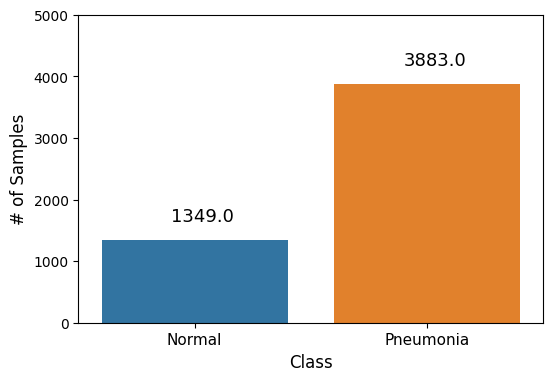

In [7]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train)

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

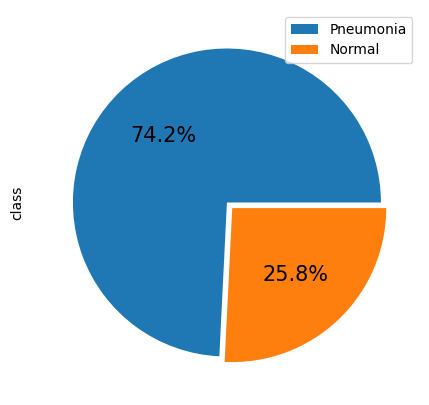

In [8]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

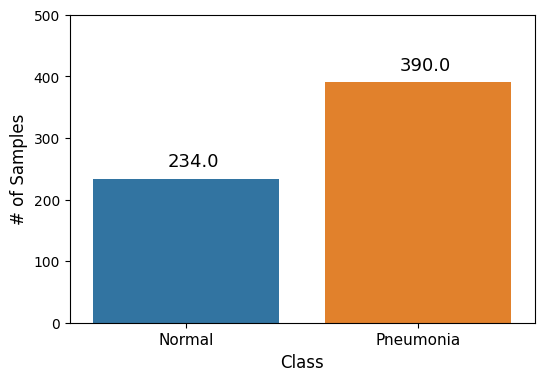

In [9]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test)

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

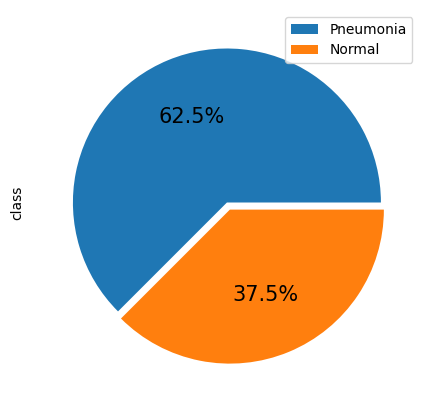

In [10]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

Train Set - Normal


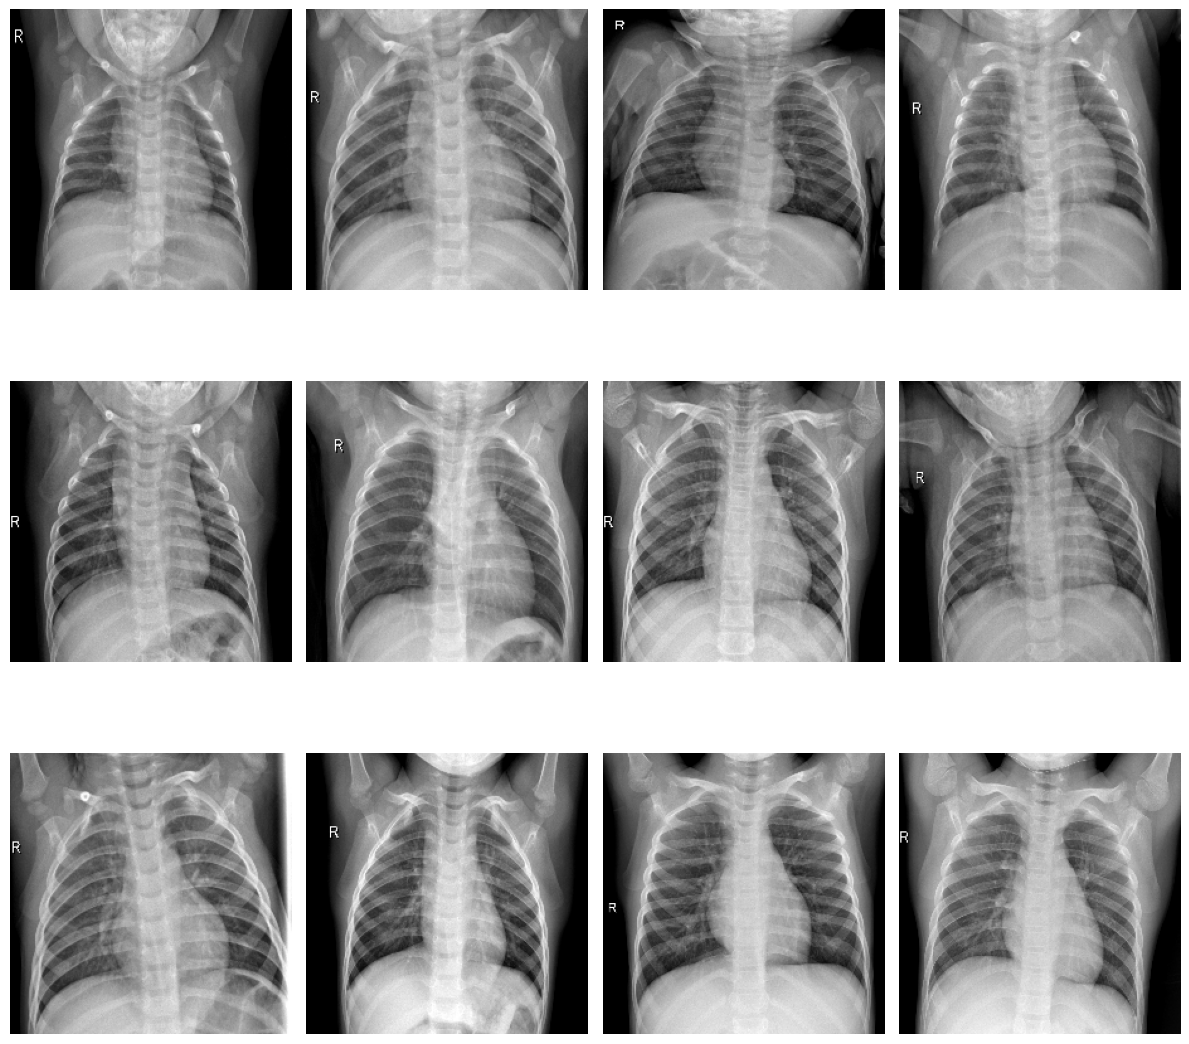

In [11]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


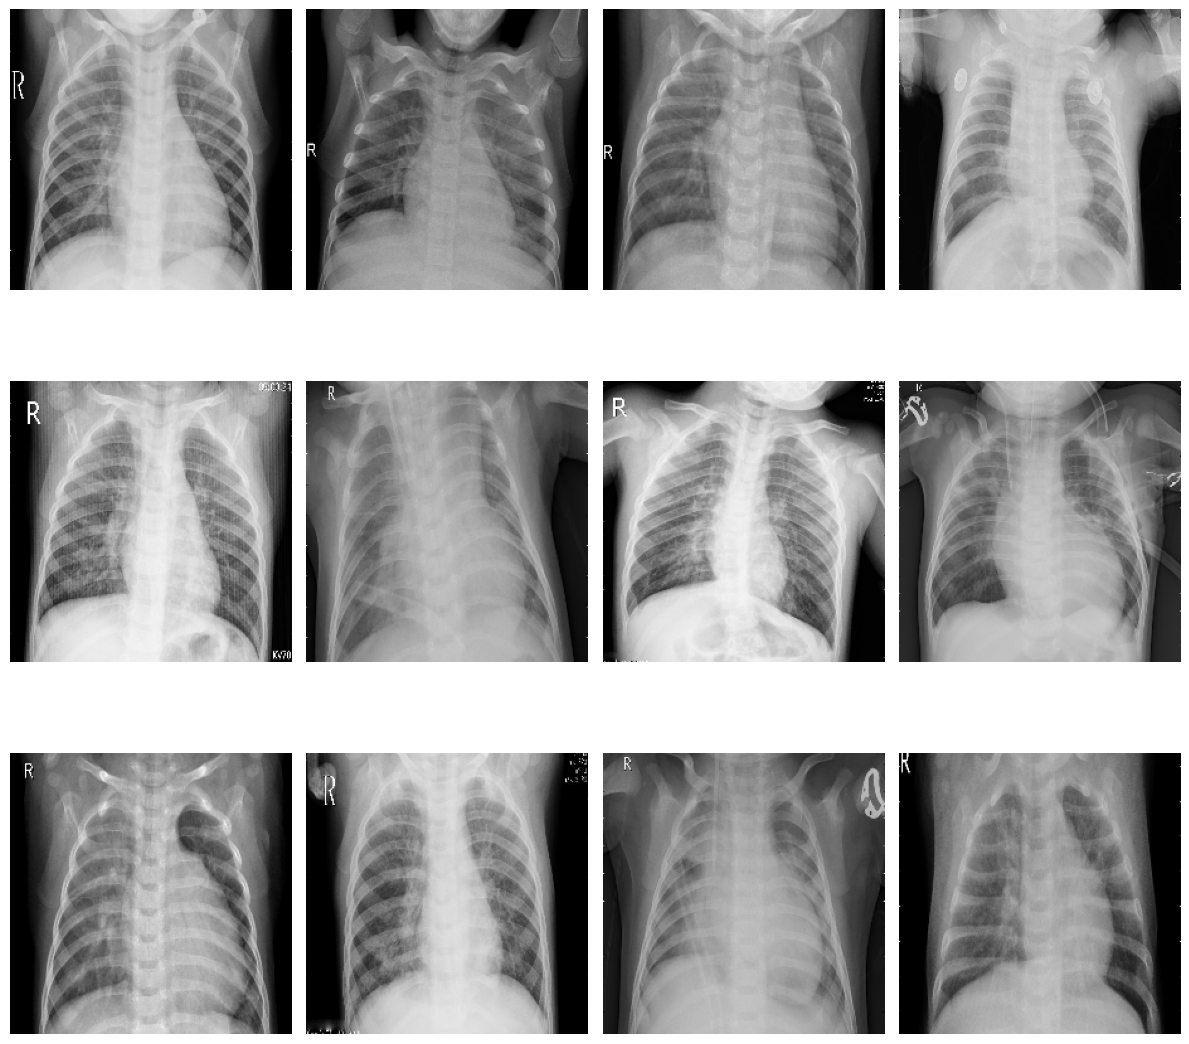

In [12]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


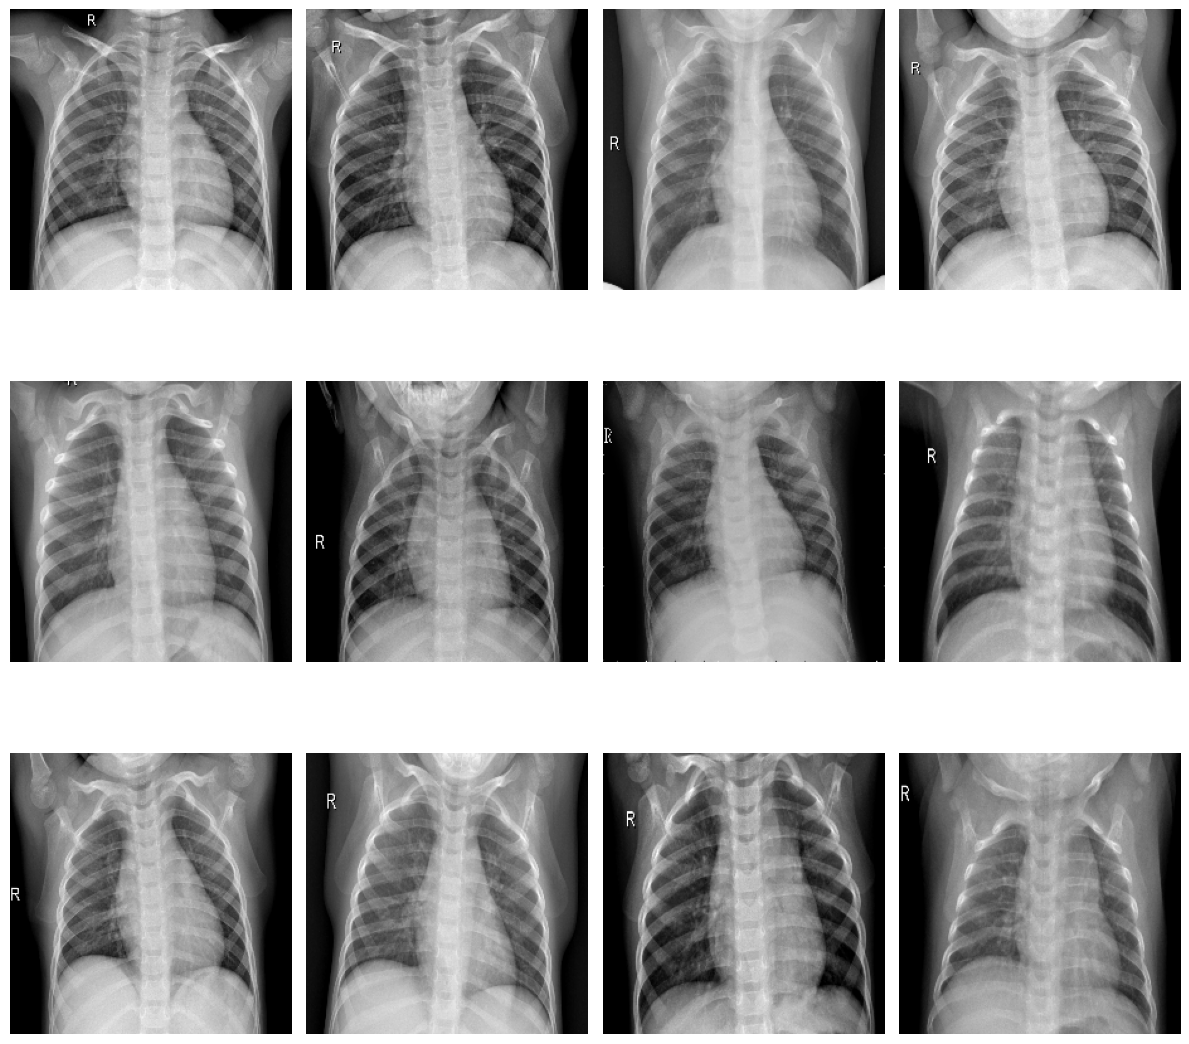

In [13]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


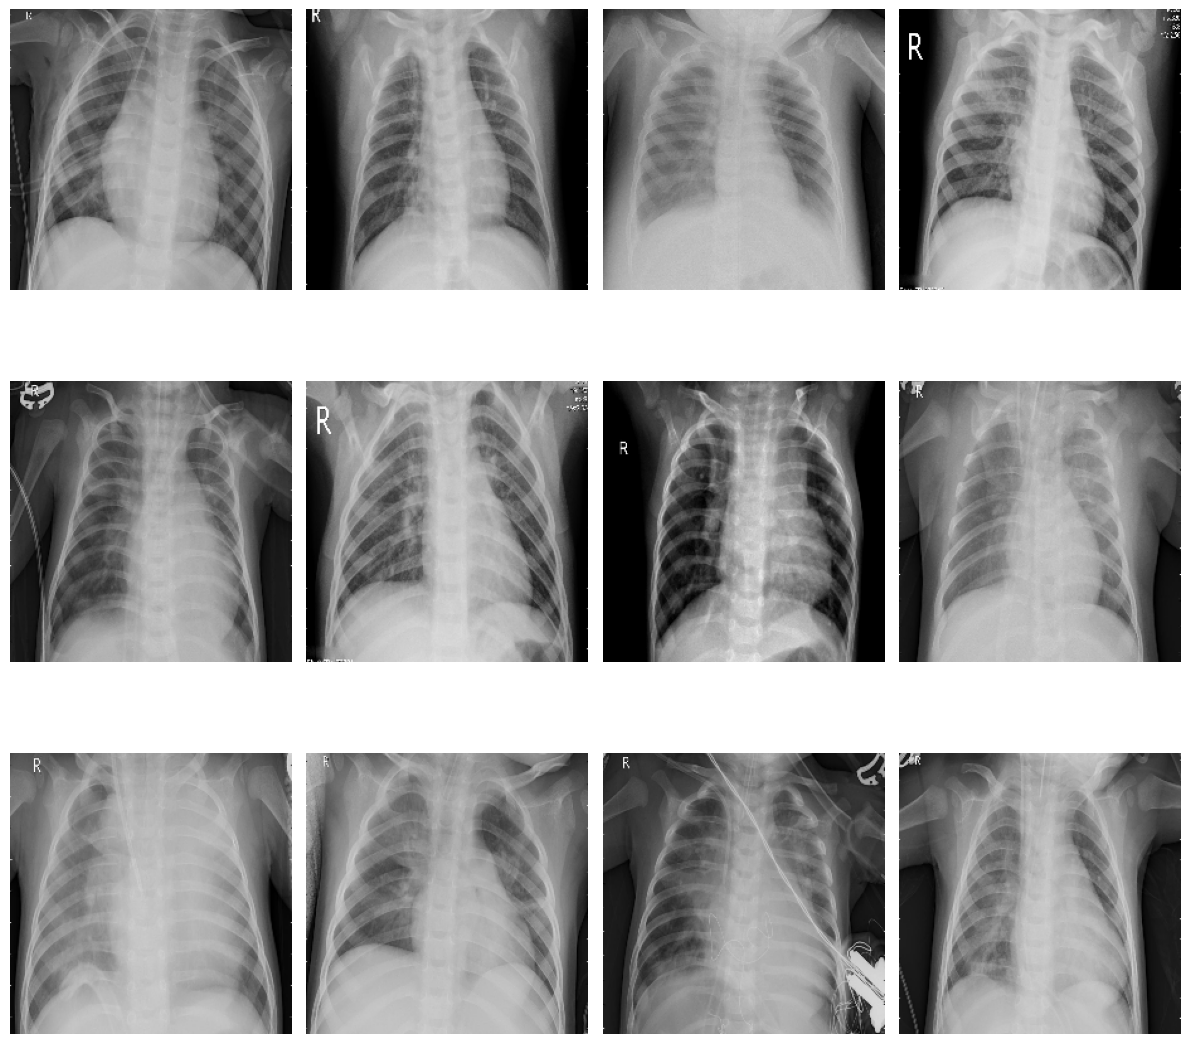

In [14]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# <a id="4">Preparing the Data</a> 

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [15]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [16]:
train_df

class  \
3566  Pneumonia   
2866  Pneumonia   
2681  Pneumonia   
1199     Normal   
4619  Pneumonia   
...         ...   
3476  Pneumonia   
678      Normal   
1560  Pneumonia   
2769  Pneumonia   
4881  Pneumonia   

                                                                                                    image  
3566  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
2866  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
2681  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
1199  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
4619  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
...                                                                                                   ...  
3476  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
678   /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
1560  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
2769  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
4881  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  

[4185 rows x 2 columns]

In [17]:
val_df

class  \
2945  Pneumonia   
4878  Pneumonia   
3177  Pneumonia   
972      Normal   
3059  Pneumonia   
...         ...   
253      Normal   
4315  Pneumonia   
687      Normal   
3417  Pneumonia   
3745  Pneumonia   

                                                                                                    image  
2945  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
4878  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
3177  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
972   /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
3059  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
...                                                                                                   ...  
253   /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
4315  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
687   /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/NORMAL/...  
3417  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  
3745  /home/rishi/Desktop/Velozity Projects/Chest X Ray for Pneumonia/chest_xray_dataset/train/PNEUMON...  

[1047 rows x 2 columns]

Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [18]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Custom CNN</a>

In [19]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

Let’s define our first model ‘from scratch’ and see how it performs.

In [20]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [21]:
# keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

2022-09-10 00:16:08.716263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:16:08.742082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:16:08.742267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:16:08.743241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50


2022-09-10 00:16:16.121597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-10 00:16:16.858790: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-10 00:16:16.859515: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-10 00:16:16.859599: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-10 00:16:16.860534: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-10 00:16:16.860693: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-10 00:16:17.880998: I tensorflow/stream_executor/cuda/c

130/130 [==============================] - 76s 552ms/step - loss: 0.5421 - binary_accuracy: 0.7491 - val_loss: 0.6786 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 71s 543ms/step - loss: 0.3619 - binary_accuracy: 0.8380 - val_loss: 1.2490 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/50
131/130 [==============================] - ETA: 0s - loss: 0.2834 - binary_accuracy: 0.8774
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 69s 528ms/step - loss: 0.2834 - binary_accuracy: 0.8774 - val_loss: 1.3476 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 71s 540ms/step - loss: 0.2413 - binary_accuracy: 0.8999 - val_loss: 1.1514 - val_binary_accuracy: 0.7421 - lr: 6.0000e-06
Epoch 5/50
130/130 [==============================] - 70s 537ms/step - loss: 0.2270 - binary_accuracy: 0.9054 - val_loss: 0.5620 - val_bin

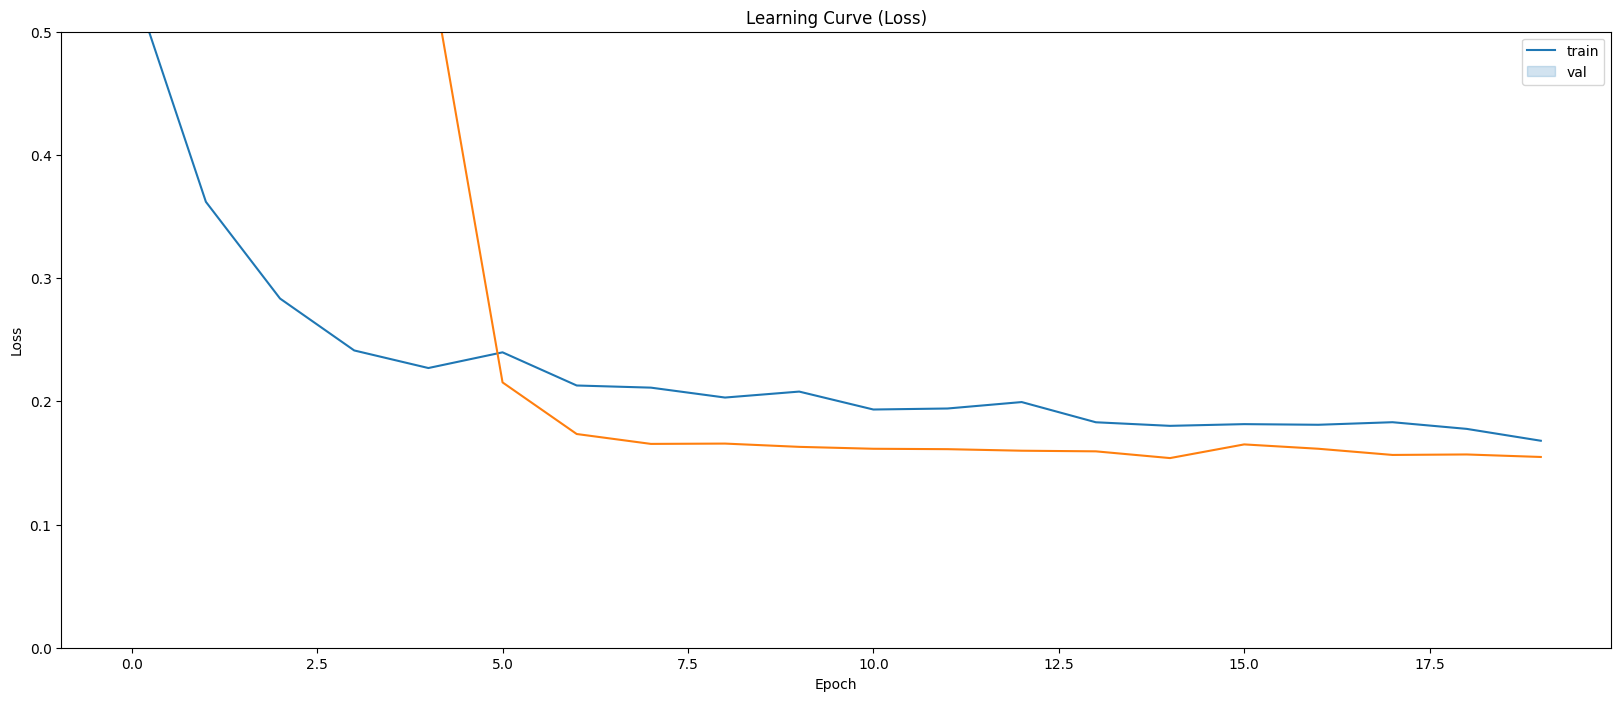

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

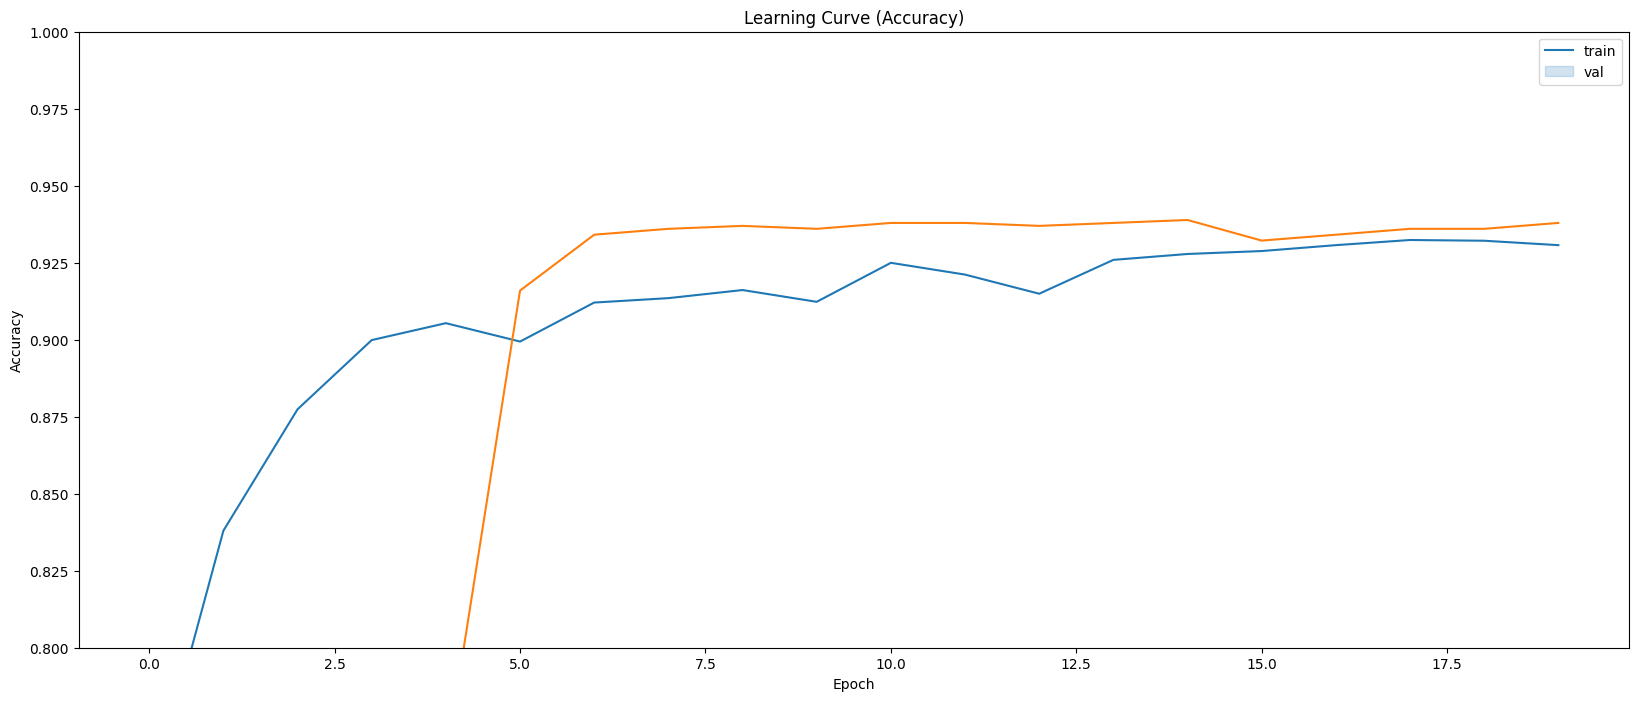

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

# <a id="6">Performance Metrics</a>

In [25]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1539277881383896
Val accuracy: 0.9388729929924011


In [26]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.414204478263855
Test accuracy: 0.8525640964508057


The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.